## Modules

In [19]:
import os
import math
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from datetime import datetime


## Loading & Cleaning Data

By taking a quick look at the dataframe we can observe some cleaning is required. The variable names are confusing as they are so we should rename them, variable 'No' serves no real purpose we could drop it, we need to parse the date, and there seems to be NaN, for the moment we will fill these with 0.

In [2]:
file_path = os.path.join(os.getcwd(), '../data/us_ambassy/PRSA_data_2010.1.1-2014.12.31.csv')
df = pd.read_csv(file_path)
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [3]:
print(df.isnull().sum()) # We confirm the missing data
print(df.shape) # Checking size of dataframe
print((df['pm2.5'] == 0).sum()) # Checking if there are null values since we will fillna with zero, and want to make that identifiable as null. There is just two which wont be relevant

No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64
(43824, 13)
2


We are missing the batch of pm2.5 data points from the first day we will drop these in the cleaning

In [4]:
# First 1k points
fig = go.Figure(data=go.Scatter(y=df['pm2.5'][:1000]))
fig.update_layout(title='PM2.5 First 1k samples', yaxis_title='Value')
fig.show()

In [5]:
old_col_names = list(df.columns) # ['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir']

new_col_names = ['pollution', 'dew', 'temp', 'pressure', 'w_dir', 'w_speed', 'snow', 'rain']

df_clean = df.set_index(df[['year', 'month', 'day', 'hour']].apply(lambda row: datetime(*row), axis=1))
df_clean.drop(columns=['year', 'month', 'day', 'hour', 'No'], axis=1, inplace=True, errors='ignore')
df_clean.columns = new_col_names
df_clean['pollution'].fillna(0, inplace=True)
df_clean = df_clean[24:]
df_clean.head()

,pollution,dew,temp,pressure,w_dir,w_speed,snow,rain
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


## Exploring Data

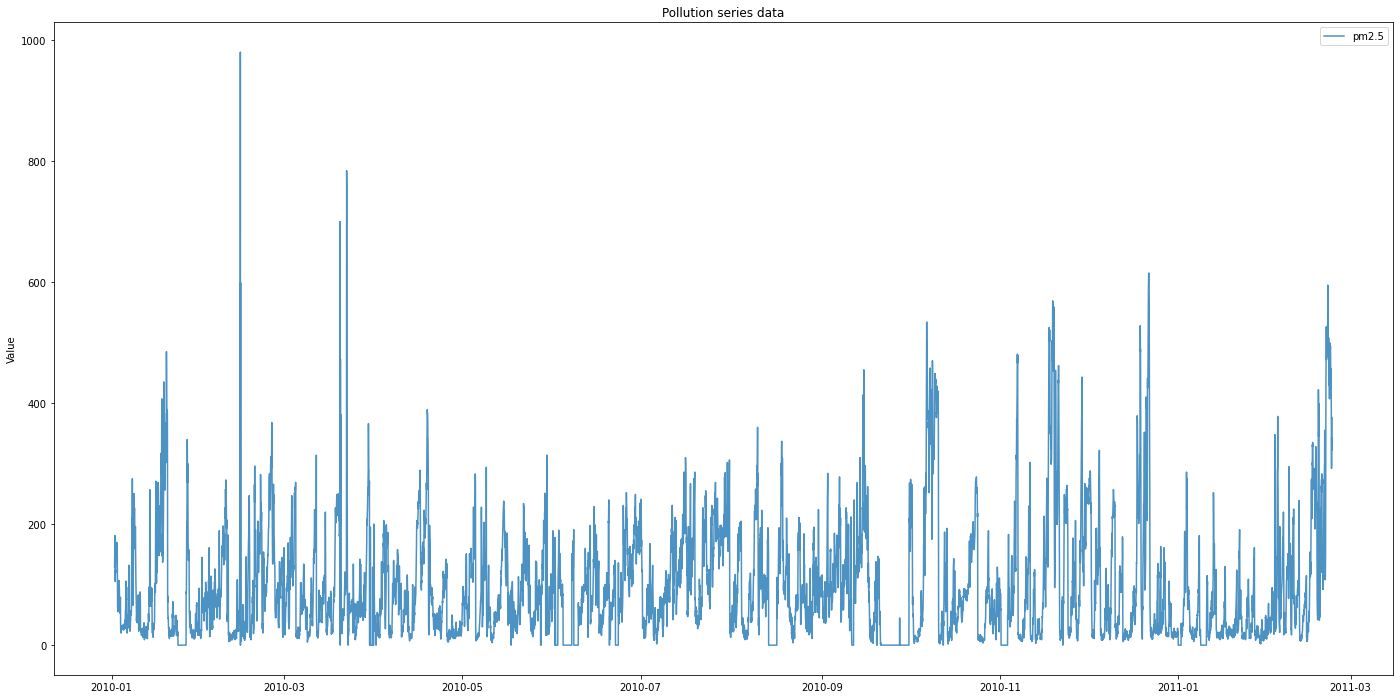

In [6]:
# Closer look at the first 10k samples
plt.figure(figsize=(24, 12))
plt.plot(df_clean['pollution'][:10000], label='pm2.5', alpha=0.8)
plt.title('Pollution series data')
plt.ylabel('Value')
plt.legend()
plt.show()

Wind speed and pollution seem to have the biggest standard deviation

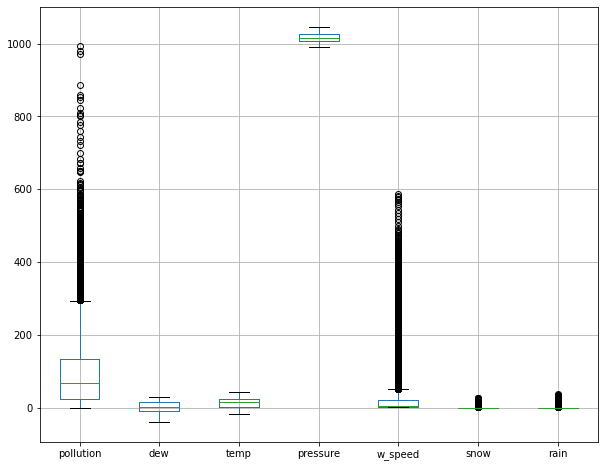

In [7]:
plt.figure(figsize=(10,8))
df_clean.boxplot()
plt.show()

Wind speed is negatively correlated to pollution (-0.2) which seems logical since wind can cause pollution particles to disperse, however, there is no significant correlation between the remaining variables except for the expected dew-temp. This makes the problem more challenging for any statistical based approach. Lets use Deep Learning.

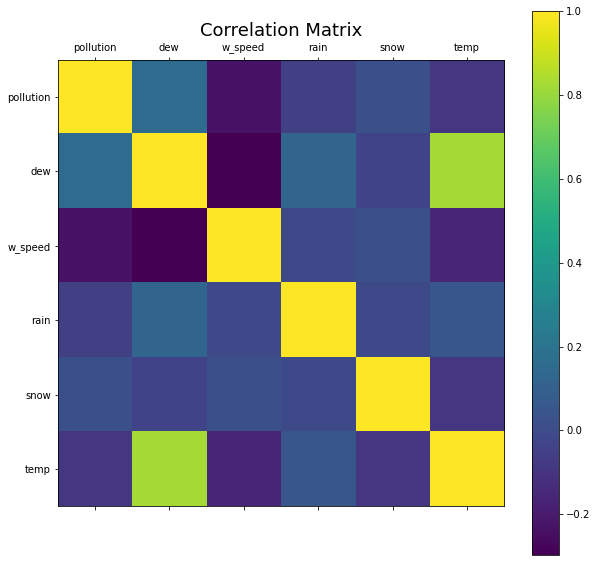

In [8]:
cor_cols = ['pollution', 'dew', 'w_speed', 'rain', 'snow', 'temp'] 

fig, ax = plt.subplots(figsize=(10,10))
cax = ax.matshow(df_clean.loc[:, cor_cols].corr())
plt.title('Correlation Matrix', fontsize=18)
plt.xticks(range(len(cor_cols)), cor_cols)
plt.yticks(range(len(cor_cols)), cor_cols)
fig.colorbar(cax)
plt.show()

## Data Preprocessing

In [9]:
# Encode categorical value
encoder = LabelEncoder()
df_clean['w_dir'] = encoder.fit_transform(df_clean['w_dir'])

In [10]:
# Scale Dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(df_clean)

In [11]:
# Generate the sequences
df = pd.DataFrame(scaled_dataset)
cols = [] 
col_names = []

n_in = 1 # No of lagged timesteps
n_out = 1 # No of timesteps to forecast
    
n_vars = scaled_dataset.shape[1] # No of variables

# generating lagged timesteps (t-n_in, ... t-1)
for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    col_names += [('%s(t-%d)' % (new_col_names[j], i)) for j in range(n_vars)] 

# Lets forecast pollution values
# generating timesteps to forecast (t, t+1, ... t+n_out-1)
cols.append(df.shift(0))
col_names += [('%s(t)' % new_col_names[j]) for j in range(n_vars)]

for i in range(1, n_out):
    cols.append(df.shift(-i))
    col_names += [('%s(t+%d)' % (new_col_names[j], i)) for j in range(n_vars)]

all_values = pd.concat(cols, axis=1)
all_values.columns = col_names
all_values.dropna(inplace=True)


# Only forecasting one variable (pollution) next hour, so drop the rest
ranges_to_drop = [((n_vars * n_in  + 1) + n_vars * (i-1), all_values.shape[1] - (n_out-i)*n_vars) for i in range(1, n_out+1)]
columns_to_drop = [list(range(start, end)) for start, end in ranges_to_drop]
columns_to_drop = [col_idx for sublist in columns_to_drop for col_idx in sublist]

all_values.drop(all_values.columns[columns_to_drop], axis=1, inplace=True)
print(all_values.head())

   pollution(t-1)  dew(t-1)  temp(t-1)  pressure(t-1)  w_dir(t-1)  \
1        0.129779  0.352941   0.245902       0.527273    0.666667   
2        0.148893  0.367647   0.245902       0.527273    0.666667   
3        0.159960  0.426471   0.229508       0.545455    0.666667   
4        0.182093  0.485294   0.229508       0.563636    0.666667   
5        0.138833  0.485294   0.229508       0.563636    0.666667   

   w_speed(t-1)  snow(t-1)  rain(t-1)  pollution(t)  
1      0.002290   0.000000        0.0      0.148893  
2      0.003811   0.000000        0.0      0.159960  
3      0.005332   0.000000        0.0      0.182093  
4      0.008391   0.037037        0.0      0.138833  
5      0.009912   0.074074        0.0      0.109658  


In [12]:
# Arranging the data as sequences for training and prediction

seq_len = 1  # sequence length or time step

X = all_values.values[:,:-1] # All but pollution column
y = all_values.values[:,-1] # Pollution column

dataX = []
dataY = []
for i in range(0, len(y) - seq_len):
    _x = X[i: i+seq_len]
    _y = y[i: i+seq_len]
    _y = _y[-1] # pick last one as the forecast target, next hour
    dataX.append(_x)
    dataY.append(_y)
    
print(dataX[0], dataY[0])

[[0.12977867 0.35294118 0.24590164 0.52727273 0.66666667 0.00229001
  0.         0.        ]] 0.1488933601609658


In [17]:
# split into train and test sets
n_train_hours = 365 * 24

dataX = np.array(dataX)
dataY = np.array(dataY)

#3D [samples, timesteps, features]
train_X, train_y = dataX[n_train_hours:], dataY[n_train_hours:]
test_X, test_y = dataX[:n_train_hours], dataY[:n_train_hours]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(35038, 1, 8) (35038,) (8760, 1, 8) (8760,)


## Model Training & Evaluation

Epoch 1/8
487/487 - 6s - loss: 0.0433 - val_loss: 0.0299 - 6s/epoch - 13ms/step
Epoch 2/8
487/487 - 2s - loss: 0.0187 - val_loss: 0.0164 - 2s/epoch - 4ms/step
Epoch 3/8
487/487 - 2s - loss: 0.0167 - val_loss: 0.0161 - 2s/epoch - 4ms/step
Epoch 4/8
487/487 - 2s - loss: 0.0158 - val_loss: 0.0157 - 2s/epoch - 4ms/step
Epoch 5/8
487/487 - 2s - loss: 0.0155 - val_loss: 0.0150 - 2s/epoch - 4ms/step
Epoch 6/8
487/487 - 2s - loss: 0.0152 - val_loss: 0.0158 - 2s/epoch - 4ms/step
Epoch 7/8
487/487 - 2s - loss: 0.0150 - val_loss: 0.0151 - 2s/epoch - 5ms/step
Epoch 8/8
487/487 - 2s - loss: 0.0150 - val_loss: 0.0157 - 2s/epoch - 4ms/step


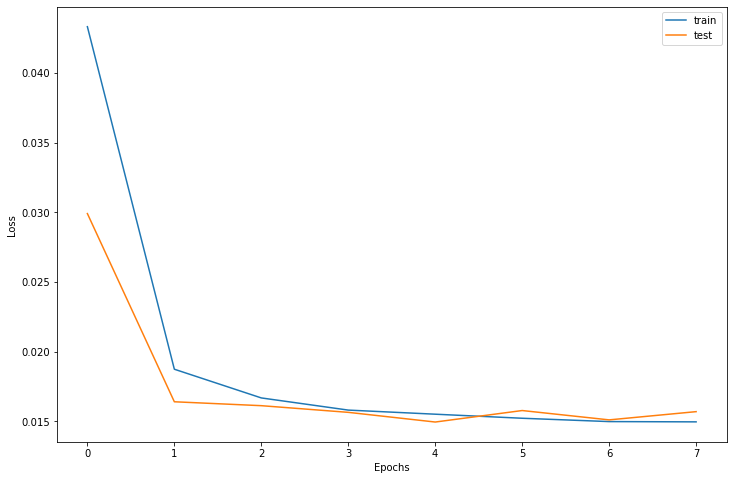

In [18]:
# Network design
model = Sequential()
model.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# Fitting Network
history = model.fit(train_X, train_y, epochs=8, 
                    batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# Plotting learning curve
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
test_predictions = model.predict(test_X)

mae = mean_absolute_error(test_y, test_predictions)
mse = mean_squared_error(test_y, test_predictions)
rmse = math.sqrt(mse)
r2 = r2_score(test_y, test_predictions)

print(f'Test MAE: {mae}')
print(f'Test RMSE: {rmse}')
print(f'Test R2: {r2}')

274/274 [==============================] - 0s 2ms/step
Test MAE: 0.015706450298996425
Test RMSE: 0.03117426941290308
Test R2: 0.888715228750374


In [29]:
# Unscaling metrics
pm_range = df_clean['pollution'].max() - df_clean['pollution'].min()
unscaled_mae = mae * pm_range
unscaled_rmse = rmse * pm_range

print(f'Test MAE: {unscaled_mae}')
print(f'Test RMSE: {unscaled_rmse}')

Test MAE: 15.612211597202446
Test RMSE: 30.987223796425663


In [22]:
df_clean['pollution'].describe()

count    43800.000000
mean        94.013516
std         92.252276
min          0.000000
25%         24.000000
50%         68.000000
75%        132.250000
max        994.000000
Name: pollution, dtype: float64

Model's results are okay, the predicted values seem to follow the series accurately with a R2 score of 0.88, an average absolute error of 15.61 and a higher root mean squared error of 30.98 which is to be expected given the nature of the time series and that this metric penalizes larger errors more. We could further attempt to optimize the network design however, this simple design seems to be providing decent performance, and complicating it with the risk of overfitting and adding unnecesary parameters might not be worth the squeeze.

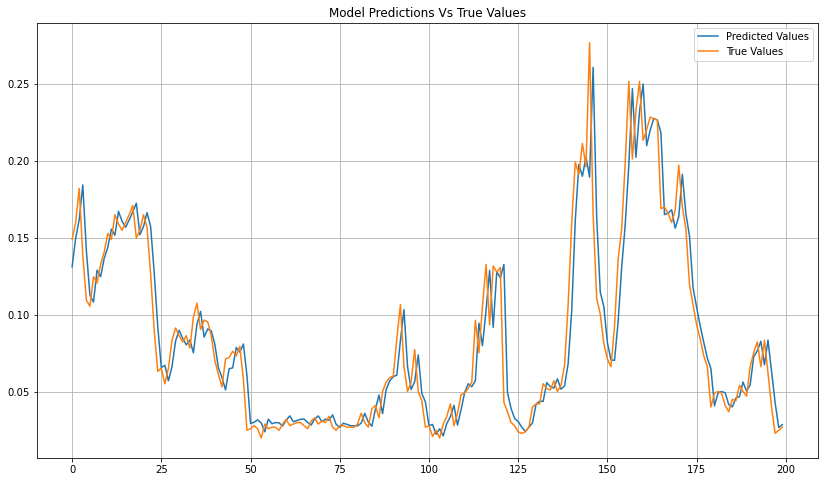

In [25]:
# Plot of model's predictions Vs true values
plt.figure(figsize=(14,8))
plt.plot(test_predictions[:200], label='Predicted Values')
plt.plot(test_y[:200], label='True Values')
plt.title('Model Predictions Vs True Values')
plt.legend()
plt.grid()
plt.show()